In [11]:
import torch
from pathlib import Path
import re
import os
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio as Audio

from src.model.model import ConvCount, config       # import model and config
from src.model.predict import *                     # lots of helpers
from src.utils.SpectrogramExtractor import SpectrogramExtractor

model = load_model('src\model\SpeakerCountCNN_comb_v1.pt')      # loads ConvCount with config

In [ ]:
long_wav = r'data/real/Test1/CoffeeTest1.wav'     # original audio
clips_dir = r'data/real/Test1/clips'        # trimmed clips destination
specs_dir = r'data/real/Test1/specs'        # spectrograms destination


save_wav_as_clips(long_wav, out_dir=clips_dir)
clips_to_specs(clips_dir=clips_dir, specs_dir=specs_dir)

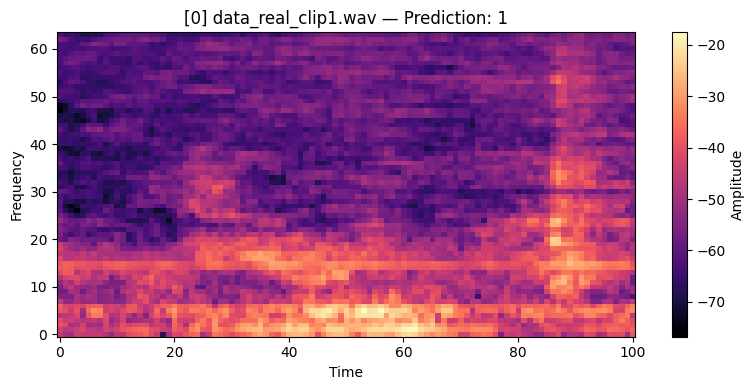

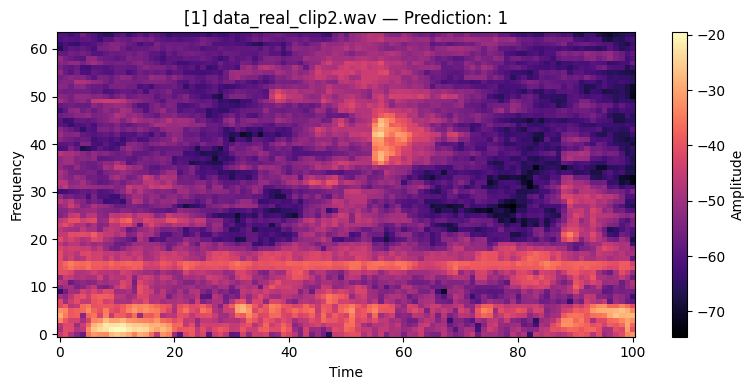

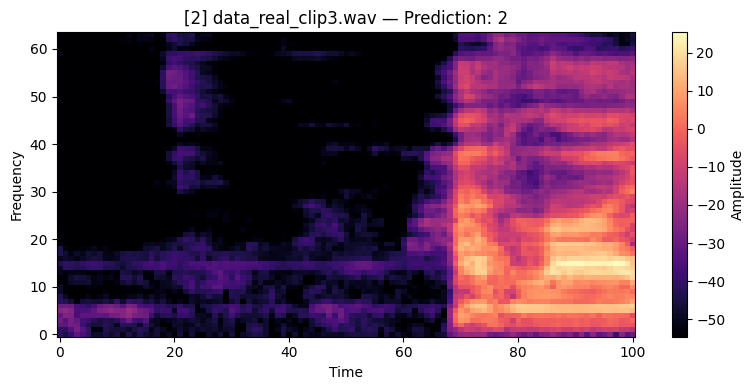

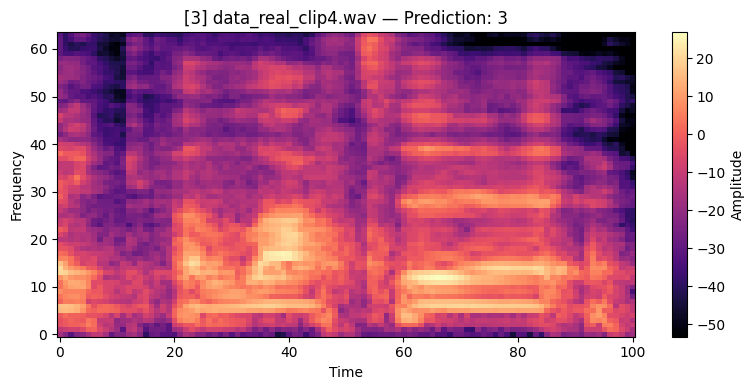

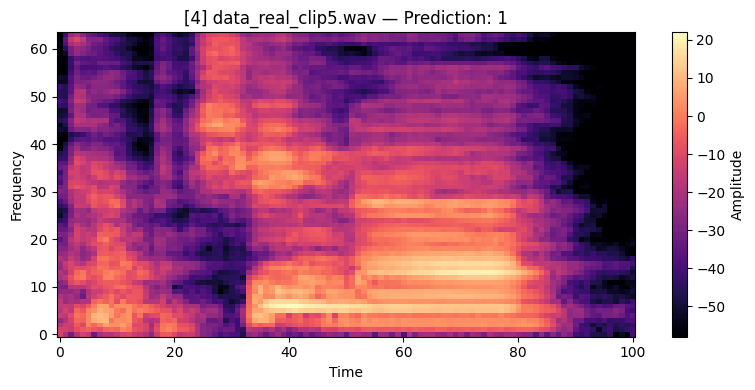

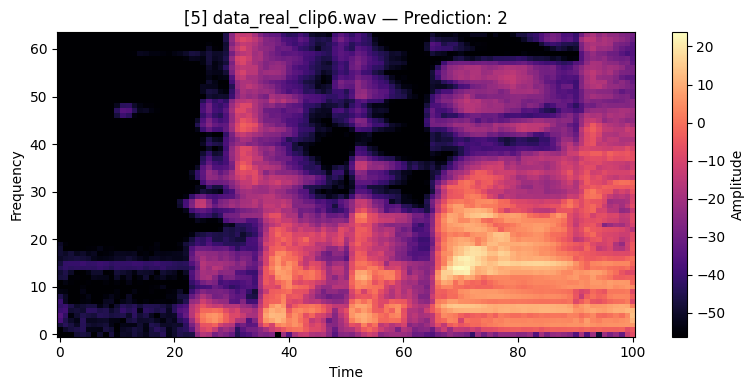

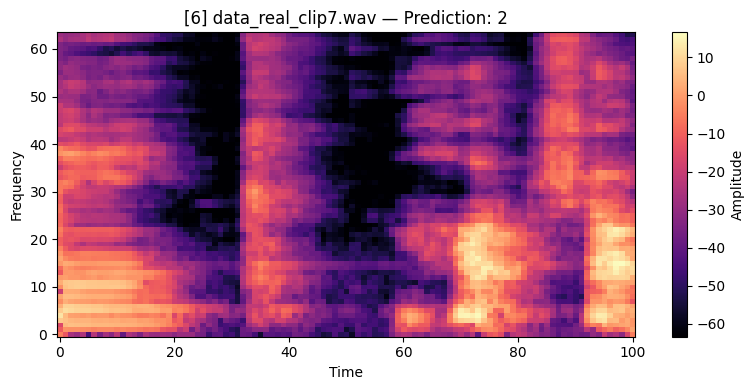

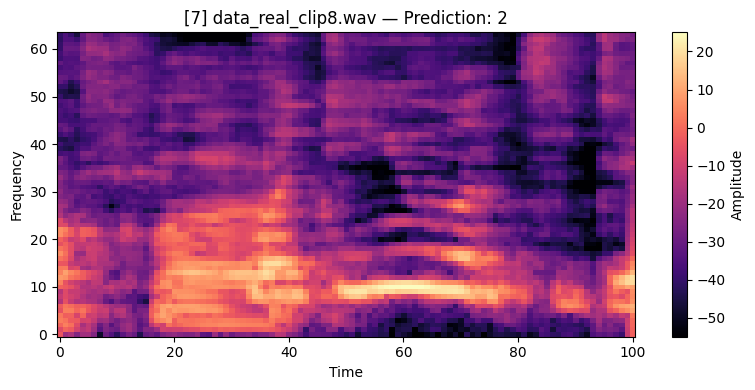

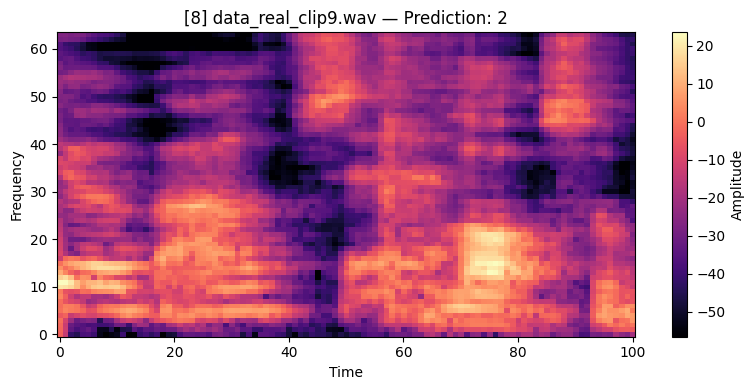

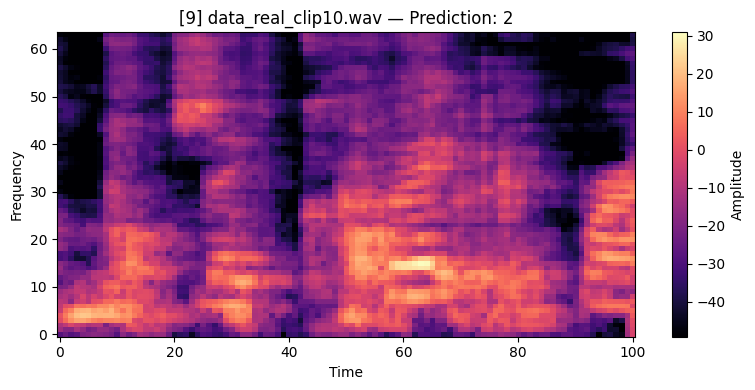

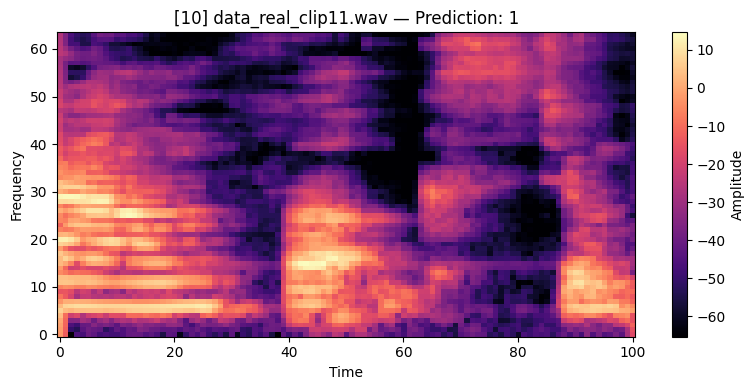

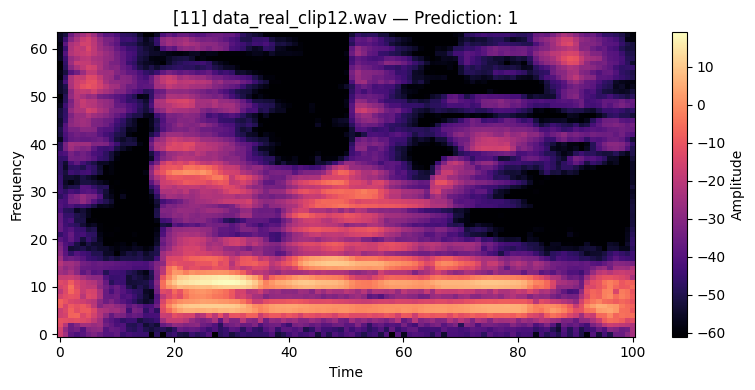

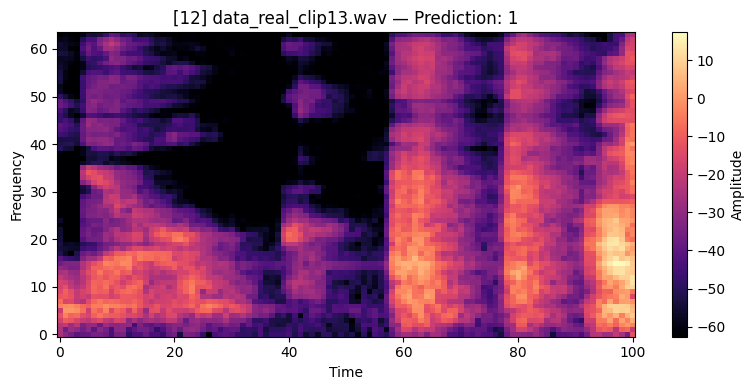

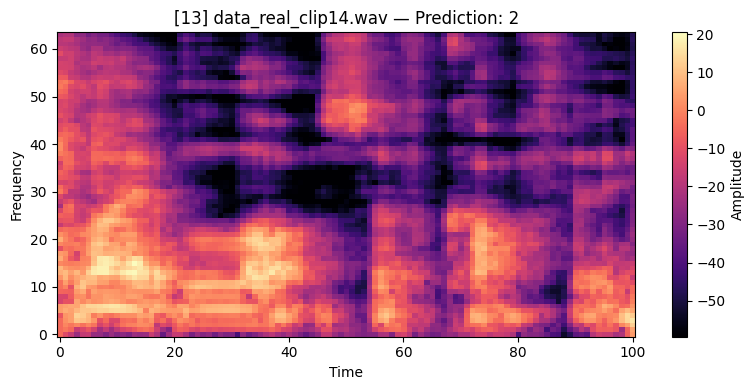

In [13]:
def natural_key(filename):
    # Extracts numeric parts of the filename for natural sorting
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('(\d+)', filename)]

for idx, spec_name in enumerate(sorted(os.listdir(specs_dir), key=natural_key)):
    if spec_name.endswith('.pt'):
        spec_path = os.path.join(specs_dir, spec_name)
        clip_name = spec_name.replace('.pt', '.wav')
        clip_path = os.path.join(clips_dir, clip_name)

        prediction = predict(spec_path, model)
        spec = load_spectrogram(spec_path).squeeze()  # adjust shape if needed

        # Show spectrogram
        plt.figure(figsize=(8, 4))
        plt.imshow(spec.numpy(), aspect='auto', origin='lower', cmap='magma')
        plt.title(f"[{idx}] {clip_name} — Prediction: {prediction}", fontsize=12)
        plt.colorbar(label='Amplitude')
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        # Play corresponding audio
        display(Audio(clip_path))
